# 0. Import , Configure , Set Seed & Ingest

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn as sk 
import re 
import html 
import os 
import bs4
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/berkcalisir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/berkcalisir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/berkcalisir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# REPRODUCIBILITY 
SEED = 42

def set_global_seed(seed):
    """
    Locks random number generators for reproducibility.
    """
    random.seed(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    np.random.seed(seed)
    
    print(f"Global Random Seed set to: {seed}")

set_global_seed(SEED)

Global Random Seed set to: 42


In [3]:
plt.style.use('ggplot')
sns.set_palette("viridis")

# 1. Exploratory Data Analysis

## 1.1. Basics

In [4]:
df = pd.read_csv("./dataset/development.csv")
df_test = pd.read_csv("./dataset/evaluation.csv")

In [5]:
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 79997 entries, 0 to 79996
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Id         79997 non-null  int64
 1   source     79997 non-null  str  
 2   title      79996 non-null  str  
 3   article    79996 non-null  str  
 4   page_rank  79997 non-null  int64
 5   timestamp  79997 non-null  str  
 6   label      79997 non-null  int64
dtypes: int64(3), str(4)
memory usage: 4.3 MB
None


In [6]:
display(df.head())

,Id,source,title,article,page_rank,timestamp,label
0,0,AllAfrica.com,OPEC Boosts Nigeria&#39;s Oil Revenue By .82m Bpd,THE Organisation of Petroleum Exporting Countr...,5,2004-09-16 22:39:53,5
1,1,Xinhua,Yearender: Mideast peace roadmap reaches dead-...,Looking back at the major events that took pla...,5,2004-12-17 19:01:14,0
2,2,Yahoo,Battleground Dispatches for Oct. 5 \\n (CQP...,CQPolitics.com - Here are today's Battleground...,5,2006-10-05 18:42:29,0
3,3,BBC,Air best to resuscitate newborns,Air rather than oxygen should be used to resus...,5,0000-00-00 00:00:00,0
4,4,Yahoo,High tech German train crash kills at least on...,"<p><a href=""http://us.rd.yahoo.com/dailynews/r...",5,2006-09-22 17:28:57,0


Problem Definition: This is a multi-class classification problem involving 7 categories (International News, Business, Technology, etc.)

Dataset Overview: approx. 100k instances and 5 features available (source, title, article, page_rank, timestamp).

## 1.2 Data Quality



We first check for how many missing values we have.

In [7]:
missing_summary= pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Percentage': df.isnull().sum() / len(df) * 100
}).sort_values('Percentage', ascending=False)

In [8]:
print("Missing Value Summary: ")
display(missing_summary)

Missing Value Summary: 


,Missing Count,Percentage
title,1,0.00125
article,1,0.00125
Id,0,0.00000
source,0,0.00000
page_rank,0,0.00000
timestamp,0,0.00000
label,0,0.00000


It's not that we have almost no missing values. They are in erroneous format. We are not able to reach them with the expected format ("NaN" or "NaT" values). We will go column by column to identify these missing values.

### a. Timestamp

In [9]:
print("Top 5 unique timestamp values:")
print(df['timestamp'].value_counts().head())

Top 5 unique timestamp values:
timestamp
0000-00-00 00:00:00    27750
2007-02-12 12:39:51        2
2007-06-22 18:43:49        2
2007-07-24 01:27:26        2
2007-02-01 07:14:50        2
Name: count, dtype: int64


The missing timestamp values are in this format: "0000-00-00 00:00:00"

In [10]:
temp_dates = pd.to_datetime(df['timestamp'], errors='coerce')
n_missing = temp_dates.isna().sum()
print(f"\nInvalid Dates (NaT after coercion): {n_missing}")
print(f"Percentage of missing dates: {(n_missing / len(df))}")


Invalid Dates (NaT after coercion): 27750
Percentage of missing dates: 0.34688800830031125


1/3 of our rows have missing dates.

### b. Pagerank

In [11]:
print(df['page_rank'].value_counts())

page_rank
5    73891
4     3692
3     2371
2       43
Name: count, dtype: int64


There is clear imbalance. 


Label Distribution by Page Rank (%)


label,0,1,2,3,4,5,6
page_rank,,,,,,,
2,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%
3,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%
4,0.0%,11.8%,58.7%,8.7%,20.8%,0.0%,0.0%
5,31.9%,13.7%,8.9%,13.1%,10.6%,17.7%,4.2%


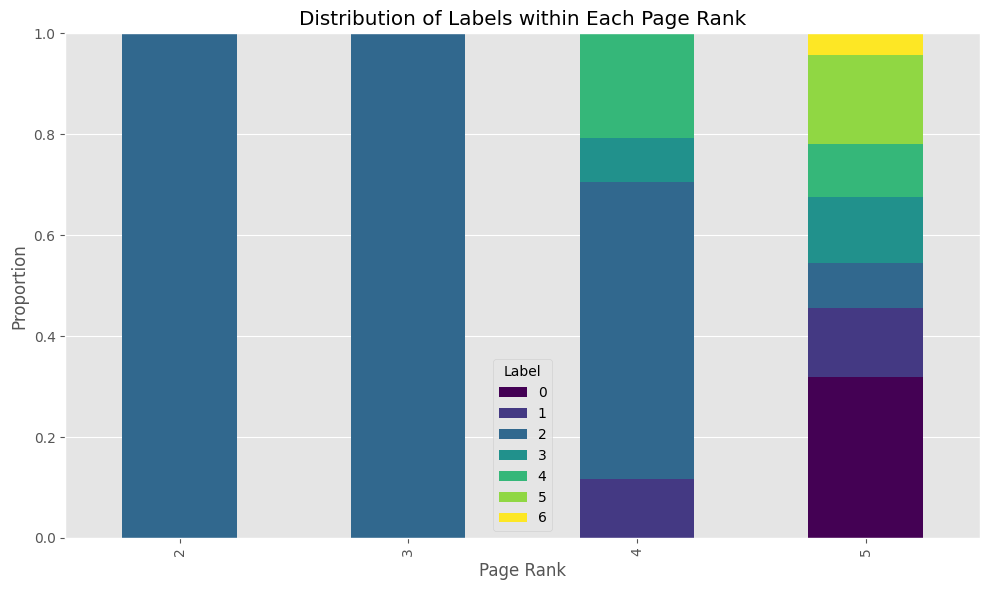

In [12]:
# We want to see if a specific Page Rank makes a certain class more likely
page_rank_label = pd.crosstab(df['page_rank'], df['label'], normalize='index')

print("\nLabel Distribution by Page Rank (%)")
display(page_rank_label.style.format("{:.1%}"))

# Visualize as a Stacked Bar Chart
page_rank_label.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Distribution of Labels within Each Page Rank')
plt.xlabel('Page Rank')
plt.ylabel('Proportion')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

Page Rank 2 and 3 are 100% Label 2 ('Technology')

### c. Source

In [13]:
display(df[df['source'].str.len() < 2])

,Id,source,title,article,page_rank,timestamp,label
1260,1260,\,Ambush wipes &#163;4bn off value of online gam...,Business: Analysts compare crash with dotcom c...,5,2006-10-03 06:55:23,5
3009,3009,\,"Is it a man's, man's, man's world?",Laura Barton checks out the feminist credentia...,5,2007-03-14 07:50:32,5
4073,4073,\,Your cash can ease troubled young minds,A counselling service that can stop pupils dev...,5,2006-12-10 07:21:38,5
11532,11532,\,Just one tablet a day could keep heart attacks...,Life: Breakthrough to prevent arteries from cl...,5,0000-00-00 00:00:00,5
19217,19217,\,Cahoot suffers online security glitch,Money: A breakdown in the security system at o...,5,0000-00-00 00:00:00,5
19410,19410,\,Surgery and drugs to tackle child obesity epid...,Calls for drastic treatment for those as young...,5,2006-12-13 05:11:55,5
20820,20820,\,Yachtswomen take unassailable Olympic lead,Olympics: Trio of sailors win Britain's first ...,5,0000-00-00 00:00:00,5
21006,21006,\,Radcliffe ready for New York marathon,Sport: Huge TV audience ready for next episode...,5,0000-00-00 00:00:00,5
21742,21742,\,Colin MacCabe: Why exams are failing children,Education: In a frank open letter to Charles C...,5,0000-00-00 00:00:00,5
23348,23348,\,Director defends rating for explicit film,Film: Winterbottom defends 9 Songs and says he...,5,2004-10-24 06:10:40,5


In [14]:
display(df[df['source'].str.len() < 3])

,Id,source,title,article,page_rank,timestamp,label
445,445,ic,Tennis: Tim slams Cup rules after defeat,TIM Henman blasted the Davis Cup rule book as ...,5,0000-00-00 00:00:00,4
573,573,\N,Bristol-Myers Posts Lower Profit,Bristol-Myers Squibb's third-quarter profit wa...,5,0000-00-00 00:00:00,1
616,616,NW,Canadian MPs urge legal action over Barrow subs,CANADIAN prime minister Paul Martin and top na...,5,0000-00-00 00:00:00,3
670,670,\N,NHL Star Heatley Sentenced; No Jail,On <a href='http://www.newsisfree.com/sources/...,5,0000-00-00 00:00:00,5
948,948,\N,Kidnap hoax woman gets first mobile ASBO,No pay-as-you-go phone for five years,5,2004-11-10 16:39:29,2
...,...,...,...,...,...,...,...
79400,79400,\,Uefa Cup: Newcastle 2 - 1 Celta Vigo,Football: Steven Taylor grabs his first goal f...,5,2006-11-24 05:12:21,5
79472,79472,DM,E-Mail ID Working Group Shuts Down Without Con...,The Internet Engineering Task Force closed its...,5,0000-00-00 00:00:00,2
79487,79487,PC,IBM Recalls Notebook Power Cords,IBM is recalling power adapters that shipped w...,5,0000-00-00 00:00:00,2
79855,79855,\N,European stocks flat as financials weigh \\n ...,FT.com - Bid activity in the steel sector led ...,5,2007-01-31 12:45:27,0


We have identified two erroneous artifacts: "\\" & "\N"

In [15]:
missing_artifacts = ['\\', '\\N', 'nan', 'NULL' ]

In [16]:
mask_source = (df['source'].str.strip() == '') | (df['source'].isin(missing_artifacts)) | df['source'].isna()
missing_source_rows = df[mask_source]
print(f"Total rows with missing source:{len(missing_source_rows)}")
display(missing_source_rows)

Total rows with missing source:328


,Id,source,title,article,page_rank,timestamp,label
573,573,\N,Bristol-Myers Posts Lower Profit,Bristol-Myers Squibb's third-quarter profit wa...,5,0000-00-00 00:00:00,1
670,670,\N,NHL Star Heatley Sentenced; No Jail,On <a href='http://www.newsisfree.com/sources/...,5,0000-00-00 00:00:00,5
948,948,\N,Kidnap hoax woman gets first mobile ASBO,No pay-as-you-go phone for five years,5,2004-11-10 16:39:29,2
1260,1260,\,Ambush wipes &#163;4bn off value of online gam...,Business: Analysts compare crash with dotcom c...,5,2006-10-03 06:55:23,5
1605,1605,\N,EU Socialists Vote for Constitution Despite Fr...,Reuters - Socialist members of the European\\n...,5,0000-00-00 00:00:00,0
...,...,...,...,...,...,...,...
78652,78652,\N,Joy (Global) to the World!,Leading manufacturer of mining equipment annou...,5,2007-12-20 21:41:27,1
78859,78859,\N,Mario Vazquez & American Idol Sued,"Magdaleno Olmos, assistant accountant for Frem...",5,2007-03-13 15:51:29,3
79373,79373,\N,Baghdad college bomber was female,A suicide bomber who killed 42 people in an at...,5,2007-02-26 11:08:52,5
79400,79400,\,Uefa Cup: Newcastle 2 - 1 Celta Vigo,Football: Steven Taylor grabs his first goal f...,5,2006-11-24 05:12:21,5


### d. Title & Article

We basically want to run the same analysis for title & article, since they are all text-based.

In [17]:
display(df[df['title'].str.len() < 4])

,Id,source,title,article,page_rank,timestamp,label
278,278,Washington,,"<br clear=""all""><a href=""http://ad.doublecli...",5,2006-11-21 17:04:52,0
19049,19049,Topix.Net,Uk,Trace your roots to the British Isles with 500...,5,0000-00-00 00:00:00,0
41473,41473,Washington,,House Committee on Energy and Commerce Subcom...,5,2006-09-28 23:33:10,2


In [18]:
display(df[df['article'].str.len() < 2])

,Id,source,title,article,page_rank,timestamp,label
654,654,CNET,Photo gallery: Robots in action,,3,0000-00-00 00:00:00,2
36842,36842,CNET,Apple may go galactic,,3,0000-00-00 00:00:00,2
47900,47900,CNET,Photo gallery: iPod gets the picture,,3,0000-00-00 00:00:00,2
66175,66175,CNET,Hitachi unleashes 100GB notebook drives,,3,0000-00-00 00:00:00,2


In [19]:
display(df[df['article'].str.len() < 3])

,Id,source,title,article,page_rank,timestamp,label
86,86,International,The Workplace: It&#x27;s called mobbing,\N,5,2007-02-05 19:22:08,1
91,91,CNN,Iraqi interim president: Insurgents gone in a ...,\N,5,2004-12-09 08:22:49,5
127,127,CNN,Tsunami doctors badly hit in Indonesia,\N,5,0000-00-00 00:00:00,5
151,151,International,Spotlight: Recruiting the recruiter,\N,5,2006-09-22 23:48:41,1
152,152,International,Gabonese hope for windfall as Chinese develop ...,\N,5,2007-02-26 14:49:23,1
...,...,...,...,...,...,...,...
79739,79739,CNN,U.S.: 109 insurgents killed,\N,5,2004-10-02 20:18:46,5
79792,79792,Forbes,Complete Coverage: Leadership,\N,5,2007-10-30 14:33:24,1
79839,79839,CNN,Hong Kong Democrats demand recount,\N,5,2004-09-13 19:04:44,5
79947,79947,Washington,Campaign for Change Resonates at the Polls,\N,5,2006-09-14 11:27:27,5


Seems like articles are also filled with "\N" and white-space related issues. We create the masks to identify rows where ANY of these columns are bad.

In [20]:
mask_title = (df['title'].str.strip() == '') | (df['title'].isin(missing_artifacts)) | (df['title'].isna())
mask_article = (df['article'].str.strip() == '') | (df['article'].isin(missing_artifacts)) | df['article'].isna()

In [21]:
missing_mask = mask_source | mask_title | mask_article
missing_rows = df[missing_mask]

In [22]:
display(missing_rows)

,Id,source,title,article,page_rank,timestamp,label
86,86,International,The Workplace: It&#x27;s called mobbing,\N,5,2007-02-05 19:22:08,1
91,91,CNN,Iraqi interim president: Insurgents gone in a ...,\N,5,2004-12-09 08:22:49,5
127,127,CNN,Tsunami doctors badly hit in Indonesia,\N,5,0000-00-00 00:00:00,5
151,151,International,Spotlight: Recruiting the recruiter,\N,5,2006-09-22 23:48:41,1
152,152,International,Gabonese hope for windfall as Chinese develop ...,\N,5,2007-02-26 14:49:23,1
...,...,...,...,...,...,...,...
79792,79792,Forbes,Complete Coverage: Leadership,\N,5,2007-10-30 14:33:24,1
79839,79839,CNN,Hong Kong Democrats demand recount,\N,5,2004-09-13 19:04:44,5
79855,79855,\N,European stocks flat as financials weigh \\n ...,FT.com - Bid activity in the steel sector led ...,5,2007-01-31 12:45:27,0
79947,79947,Washington,Campaign for Change Resonates at the Polls,\N,5,2006-09-14 11:27:27,5


Unless we missed anything, we can confirm that there are 2204 rows with missing values. 

We will use these masks to normalize missing values. We don't intend to remove any row, unless there is absolutely no data to help us. For example, let's say we removed a row because it had no title or article. That row's source, page_rank & timestamp could still hold valuable information. We will check which are the rows that contain the least amount of information, but be cautious when choosing to remove them.

In [23]:
def clean_and_analyze_dataset(df):
    """
    Performs mechanical cleaning and returns both the cleaned dataframe
    and a summary of the data quality issues found using masks.
    """
    df_clean = df.copy()

    # Define Artifacts
    missing_artifacts = ['\\N', '\\', 'nan', 'NULL']

    # Create Masks
    mask_source = (df_clean['source'].str.strip() == '') | (df_clean['source'].isin(missing_artifacts)) | df_clean['source'].isna()
    mask_title = (df_clean['title'].str.strip() == '') | (df_clean['title'].isin(missing_artifacts)) | df_clean['title'].isna()
    mask_article = (df_clean['article'].str.strip() == '') | (df_clean['article'].isin(missing_artifacts)) | df_clean['article'].isna()

    mask_text = mask_source | mask_title | mask_article

    # Apply Cleaning (Standardize to np.nan)
    df_clean.loc[mask_source, 'source'] = np.nan
    df_clean.loc[mask_title, 'title'] = np.nan
    df_clean.loc[mask_article, 'article'] = np.nan

    # Handle Timestamps
    # Coerce errors to NaT
    df_clean['timestamp_clean'] = pd.to_datetime(df_clean['timestamp'], errors='coerce')
    mask_date_issue = df_clean['timestamp_clean'].isna()
    # Replace original column
    df_clean['timestamp'] = df_clean['timestamp_clean']
    df_clean.drop(columns=['timestamp_clean'], inplace=True)

    # Handle Page Rank
    # Coerce non-numeric to NaN
    df_clean['page_rank'] = pd.to_numeric(df_clean['page_rank'], errors='coerce')

    # Generate Report Stats
    stats = {
        'total_rows': len(df),
        'missing_source': mask_source.sum(),
        'missing_title': mask_title.sum(),
        'missing_article': mask_article.sum(),
        'rows_with_any_text_missing': mask_text.sum(),
        'missing_dates': mask_date_issue.sum(),
        'pct_missing_dates': (mask_date_issue.sum() / len(df)) * 100
    }

    return df_clean, stats

In [24]:
# Apply the cleaning
df_clean, quality_stats = clean_and_analyze_dataset(df)

print("--- Data Quality Report ---")
print(f"Total Rows: {quality_stats['total_rows']}")
print(f"Rows with Missing Source: {quality_stats['missing_source']}")
print(f"Rows with Missing Title: {quality_stats['missing_title']}")
print(f"Rows with Missing Article: {quality_stats['missing_article']}")
print(f"Rows with ANY Text Missing: {quality_stats['rows_with_any_text_missing']}")
print("-" * 30)
print(f"Rows with Invalid/Missing Dates: {quality_stats['missing_dates']}")
print(f"Percentage of Missing Dates: {quality_stats['pct_missing_dates']:.2f}%")

--- Data Quality Report ---
Total Rows: 79997
Rows with Missing Source: 328
Rows with Missing Title: 3
Rows with Missing Article: 1882
Rows with ANY Text Missing: 2204
------------------------------
Rows with Invalid/Missing Dates: 27750
Percentage of Missing Dates: 34.69%


Since we have purely NaN and NaT values now, we rely on the fact that Pandas duplicated() considers NaN equal to NaN, which helps us find duplicates even in incomplete rows.

In [25]:
# We ignore 'id' because that's just a database index.
subset_cols = ['title', 'article', 'source', 'timestamp', 'page_rank']
dup_content = df_clean[df_clean.duplicated(subset=subset_cols, keep=False)]

print(f"Rows with duplicate Content: {len(dup_content)}")

# Let's peek at an example of content duplicates if they exist
if not dup_content.empty:
    print("\nExample of Content Duplicates:")
    # Sort by title so duplicates appear next to each other
    display(dup_content.sort_values(by='title').head(4))

Rows with duplicate Content: 1559

Example of Content Duplicates:


,Id,source,title,article,page_rank,timestamp,label
1936,1936,USA,&#39;Age is just a number&#39; to leader Haas,"Jay Haas, who turns 51 on Dec. 2, leads the To...",5,NaT,5
5575,5575,USA,&#39;Age is just a number&#39; to leader Haas,"Jay Haas, who turns 51 on Dec. 2, leads the To...",5,NaT,4
37295,37295,CNN,&#39;Chemical Ali&#39; faces questions at hearing,Captured former Iraqi official Ali Hassan al-M...,5,NaT,3
68290,68290,CNN,&#39;Chemical Ali&#39; faces questions at hearing,Captured former Iraqi official Ali Hassan al-M...,5,NaT,0


This is troubling. There are rows with fully duplicate content (source, title, article, page_rank, timestamp) but different labels. 

We have to detect these conflicts by finding groups with the same content (title, article, source) but different labels.

If a conflicted row is labeled "General News" (5) and its duplicate is "Sports" (4), the specific label is almost always the correct one. We keep the "Sports" row.

If a row is "Sports" and its duplicate is "Business", we can't know the truth. We drop both to prevent confusing the model.

Deduplicate the Rest: For the remaining redundant rows (same label), we will keep the one with the earliest timestamp.

In [26]:
def deduplicate(df):
    """
    Removes duplicates:
    1. Prefer specific topics (Sports, Tech) over 'General News'.
    2. Prefer earlier timestamps.
    3. Drop rows with irreconcilable conflicts (e.g. same text is both 'Sports' and 'Business').
    """
    # Use a working copy to avoid SettingWithCopy warnings
    df_clean = df.copy()
    
    content_definition_columns = ['title', 'article', 'source']
    df_clean['is_generic_label'] = (df_clean['label'] == 5)
    
    # Sort by:
    #   1. Title (group duplicates together)
    #   2. Is Generic? (Specific labels float to top)
    #   3. Timestamp (Earliest date floats to top)
    df_clean = df_clean.sort_values(
        by=['title', 'is_generic_label', 'timestamp'], 
        ascending=[True, True, True]
    )
    
    # Identify Irreconcilable Conflicts
    # A conflict is "irreconcilable" if the same content has multiple DIFFERENT 
    # specific labels (e.g., one row is 'Sports', another is 'Business').
    
    # Filter to only rows that have specific (non-general) labels
    has_specific_label_mask = df_clean['label'] != 5
    rows_with_specific_labels = df_clean[has_specific_label_mask]
    
    # Count unique labels per content group
    label_counts_per_content = rows_with_specific_labels.groupby(content_definition_columns)['label'].nunique()
    
    # Identify content that has >1 specific label (Contradiction)
    content_with_contradictions = label_counts_per_content[label_counts_per_content > 1].index
    
    # Remove Irreconcilable Rows
    if len(content_with_contradictions) > 0:
        print(f"Dropping {len(content_with_contradictions)} articles with impossible label conflicts.")
        # Set index to allow easy dropping by content tuple
        df_clean = df_clean.set_index(content_definition_columns)
        df_clean = df_clean.drop(index=content_with_contradictions).reset_index()
    
    # Deduplicate Remaining Rows
    initial_row_count = len(df_clean)
    df_final = df_clean.drop_duplicates(subset=content_definition_columns, keep='first')
    
    # Clean up helper column
    df_final = df_final.drop(columns=['is_generic_label'])
    
    rows_removed = initial_row_count - len(df_final)
    print(f"Smart Deduplication Complete. Removed {rows_removed} redundant rows.")
    print(f"Final Dataset Size: {len(df_final)} rows.")
    
    return df_final

In [27]:
df_clean = deduplicate(df_clean)

Dropping 519 articles with impossible label conflicts.
Smart Deduplication Complete. Removed 2275 redundant rows.
Final Dataset Size: 76613 rows.


In [28]:
def plot_cleaning_impact(df_raw, df_clean):
    raw_counts = df_raw['label'].value_counts().sort_index()
    clean_counts = df_clean['label'].value_counts().sort_index()
    
    label_map = {
        0: 'International (0)', 1: 'Business (1)', 2: 'Technology (2)',
        3: 'Entertainment (3)', 4: 'Sports (4)', 5: 'General (5)', 6: 'Health (6)'
    }
    
    comparison = pd.DataFrame({
        'Label': [label_map[i] for i in raw_counts.index],
        'Raw': raw_counts.values,
        'Cleaned': clean_counts.values
    })
    
    comparison_melt = comparison.melt(id_vars='Label', var_name='Dataset', value_name='Count')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=comparison_melt, x='Label', y='Count', hue='Dataset', palette=['#d3d3d3', '#1f77b4'])
    
    plt.title('Impact of Cleaning on Class Distribution', fontsize=14)
    plt.ylabel('Number of Articles')
    plt.xlabel('Category')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    for i, label in enumerate(comparison['Label']):
        raw_val = comparison.loc[i, 'Raw']
        clean_val = comparison.loc[i, 'Cleaned']
        drop_pct = ((raw_val - clean_val) / raw_val) * 100
        
        plt.text(i + 0.2, clean_val + 500, f'-{drop_pct:.1f}%', 
                 ha='center', va='bottom', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.show()
    
    return comparison

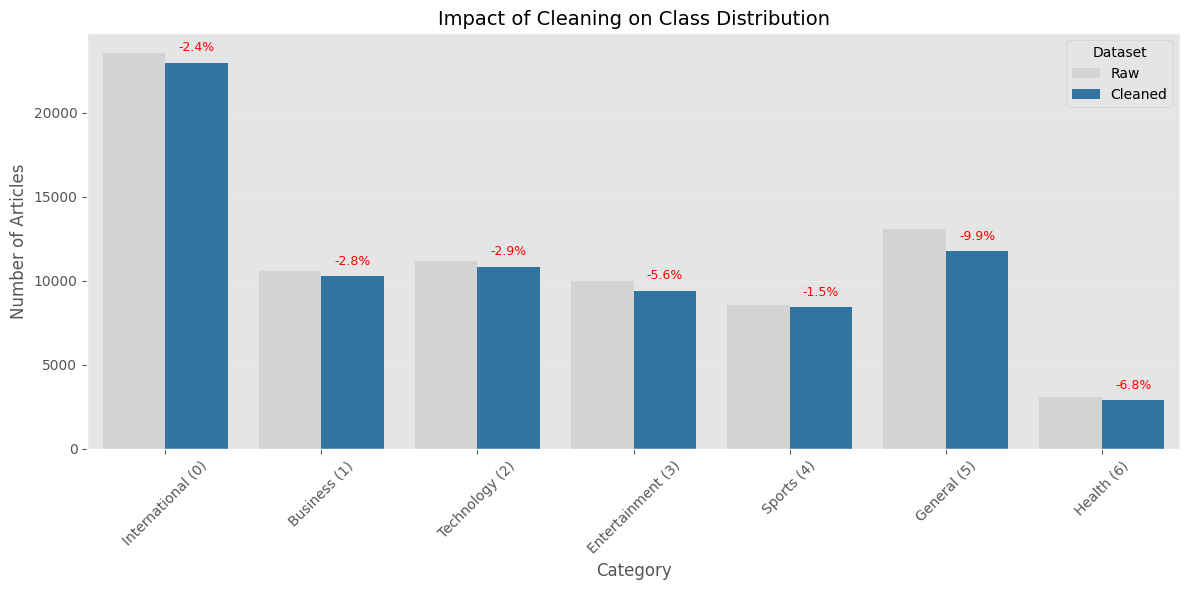

,Label,Raw,Cleaned
0,International (0),23542,22973
1,Business (1),10588,10292
2,Technology (2),11161,10834
3,Entertainment (3),9977,9416
4,Sports (4),8574,8445
5,General (5),13053,11761
6,Health (6),3102,2892


In [29]:
impact_stats = plot_cleaning_impact(df, df_clean)
display(impact_stats)

## 1.3 Univariate Analysis

### a. Summary

In [30]:
missing_summary= pd.DataFrame({
    'Missing Count': df_clean.isnull().sum(),
    'Percentage': df_clean.isnull().sum() / len(df) * 100
}).sort_values('Percentage', ascending=False)

In [31]:
print("Missing Value Summary: ")
display(missing_summary)

Missing Value Summary: 


,Missing Count,Percentage
timestamp,26341,32.927485
article,1865,2.331337
source,328,0.410015
title,3,0.003750
Id,0,0.000000
page_rank,0,0.000000
label,0,0.000000


### b. Source Distribution

/var/folders/kk/clxttl7j5wvbs_fcnydk843r0000gn/T/ipykernel_32694/504283468.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='Source', y='Count', palette='viridis')


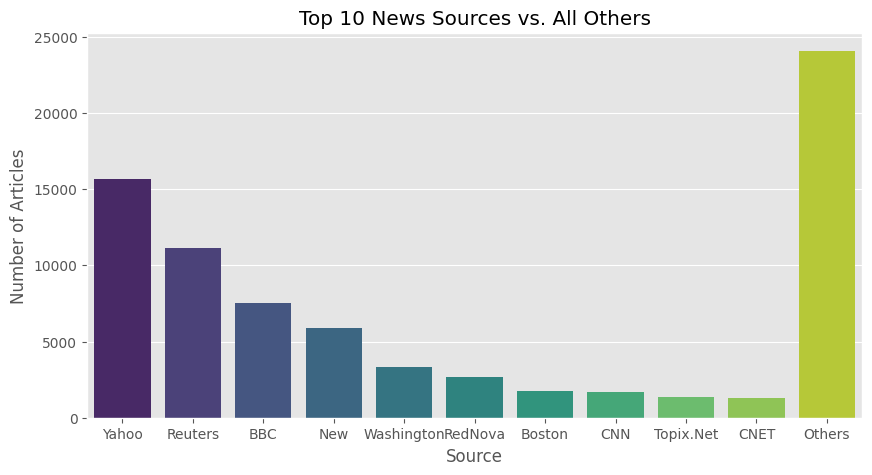

In [32]:
# Configuration
top_n_sources = 10

# Calculate counts
source_counts = df_clean['source'].value_counts()
top_sources = source_counts.head(top_n_sources)
other_count = source_counts.iloc[top_n_sources:].sum()

# Create dataframe for plotting
plot_data = pd.DataFrame({
    'Source': top_sources.index.tolist() + ['Others'],
    'Count': top_sources.values.tolist() + [other_count]
})

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=plot_data, x='Source', y='Count', palette='viridis')
plt.title(f'Top {top_n_sources} News Sources vs. All Others')
plt.ylabel('Number of Articles')
plt.show()

### c. Timestamp Analysis (Train vs. Test)

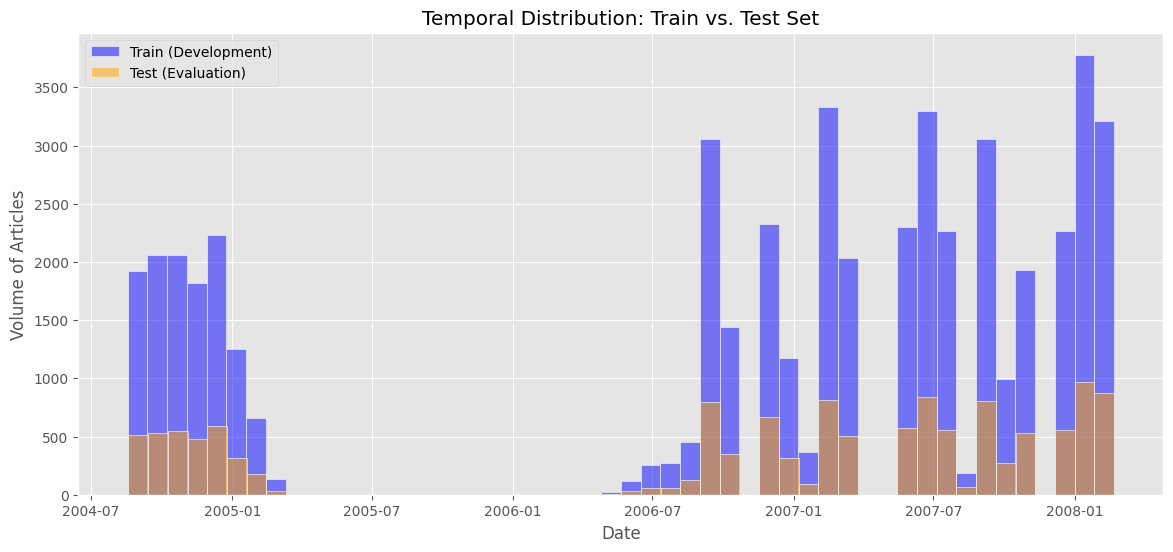

In [33]:
try:
    df_eval = pd.read_csv('./dataset/evaluation.csv')
    df_eval['timestamp'] = pd.to_datetime(df_eval['timestamp'], errors='coerce')
    has_eval = True
except FileNotFoundError:
    print("Evaluation set not found. Plotting Train only.")
    has_eval = False

plt.figure(figsize=(14, 6))

# Plot Train (Blue)
sns.histplot(df_clean['timestamp'], color='blue', label='Train (Development)', kde=False, bins=50, alpha=0.5)

# Plot Test (Orange) if available
if has_eval:
    sns.histplot(df_eval['timestamp'], color='orange', label='Test (Evaluation)', kde=False, bins=50, alpha=0.5)

plt.title('Temporal Distribution: Train vs. Test Set')
plt.xlabel('Date')
plt.ylabel('Volume of Articles')
plt.legend()
plt.show()

### d. Text Lengths

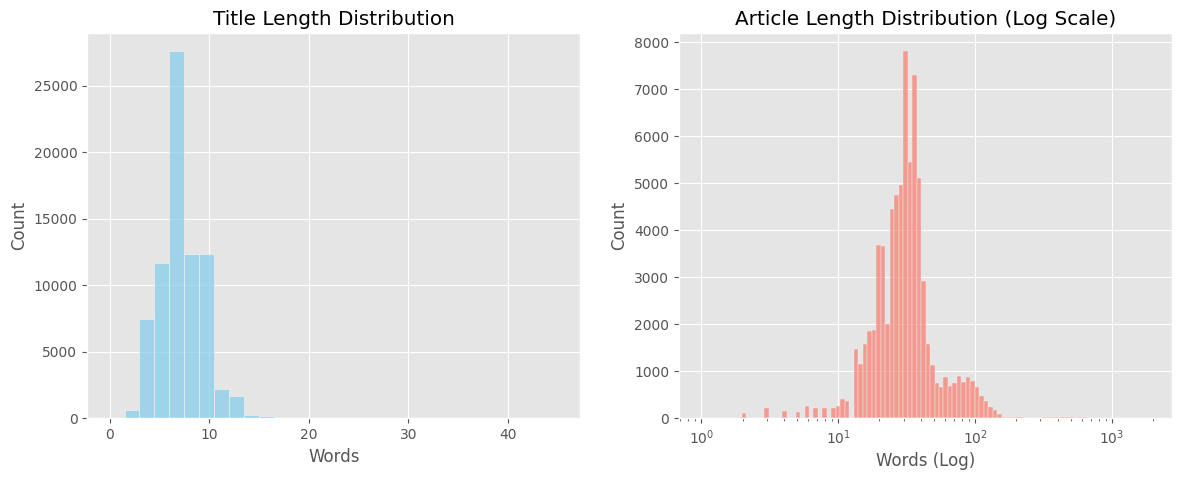

Article Length Stats:
 count    76613.0
mean        36.1
std         40.2
min          0.0
25%         22.0
50%         30.0
75%         38.0
max       1888.0
Name: article_len, dtype: float64


In [34]:
df_clean['title_len'] = df_clean['title'].str.split().str.len().fillna(0).astype(int)
df_clean['article_len'] = df_clean['article'].str.split().str.len().fillna(0).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Title Length
sns.histplot(df_clean['title_len'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Title Length Distribution')
axes[0].set_xlabel('Words')

# Article Length (Log Scale)
sns.histplot(df_clean['article_len'], bins=100, ax=axes[1], color='salmon', log_scale=True)
axes[1].set_title('Article Length Distribution (Log Scale)')
axes[1].set_xlabel('Words (Log)')

plt.show()

# Print stats for report
print("Article Length Stats:\n", df_clean['article_len'].describe().round(1))

## 1.4 Bi-Variate Analysis


### a. Source vs. Label

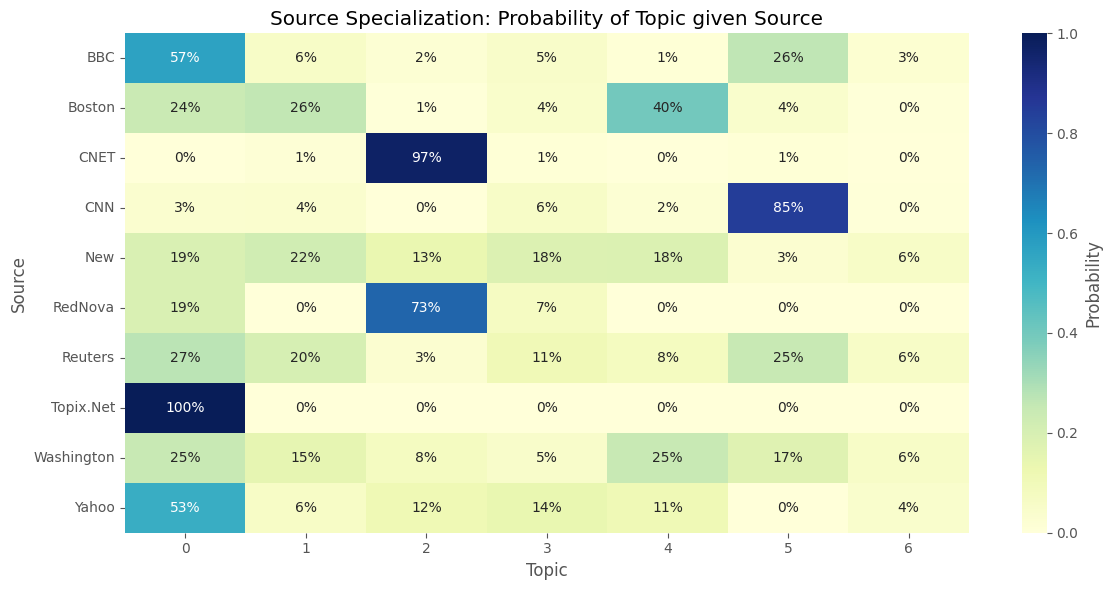

In [35]:
# We focus on the Top 10 sources to keep the heatmap readable
top_10_sources = df_clean['source'].value_counts().head(10).index
df_top_source = df_clean[df_clean['source'].isin(top_10_sources)]

# Create Cross-tabulation (normalized by row/source)
ct = pd.crosstab(df_top_source['source'], df_top_source['label'], normalize='index')

plt.figure(figsize=(12, 6))
sns.heatmap(ct, annot=True, fmt='.0%', cmap='YlGnBu', cbar_kws={'label': 'Probability'})
plt.title('Source Specialization: Probability of Topic given Source')
plt.ylabel('Source')
plt.xlabel('Topic')
plt.tight_layout()
plt.show()

### b. Content Length vs. Label

/var/folders/kk/clxttl7j5wvbs_fcnydk843r0000gn/T/ipykernel_32694/2324578317.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


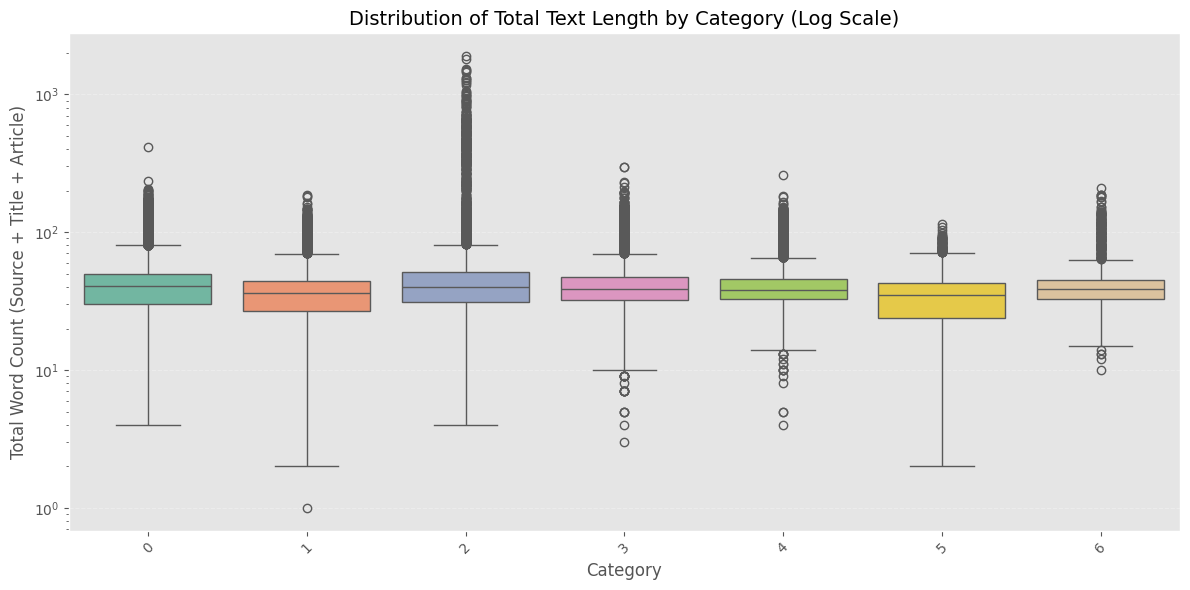

Median Word Counts by Category:
label
0    41.0
2    40.0
3    39.0
6    39.0
4    38.0
1    36.0
5    35.0
Name: total_len, dtype: float64


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create Merged Text Feature (Source + Title + Article)
# We fill NaN with empty strings to avoid "Reuters nan nan" artifacts
df_clean['merged_text'] = (
    df_clean['source'].fillna('') + " " + 
    df_clean['title'].fillna('') + " " + 
    df_clean['article'].fillna('')
)
# Calculate Word Count for the merged text
df_clean['total_len'] = df_clean['merged_text'].str.split().str.len().fillna(0).astype(int)

# Visualization
plt.figure(figsize=(12, 6))

# Boxplot with log scale for y-axis
sorted_labels = sorted(df_clean['label'].unique())

sns.boxplot(
    data=df_clean, 
    x='label', 
    y='total_len', 
    order=sorted_labels, 
    palette='Set2'
)

plt.yscale('log') 

plt.title('Distribution of Total Text Length by Category (Log Scale)', fontsize=14)
plt.ylabel('Total Word Count (Source + Title + Article)')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print Summary Statistics (for the report text)
print("Median Word Counts by Category:")
print(df_clean.groupby('label')['total_len'].median().sort_values(ascending=False))

In [41]:
df_clean.tail(20)

,title,article,source,Id,page_rank,timestamp,label,title_len,article_len,merged_text,total_len
78868,âTempoâ Chief Editor Remains Valiant,Laksamana.Net - Despite being sentenced to one...,Laksamana,79119,5,NaT,0,5,42,Laksamana âTempoâ Chief Editor Remains Val...,48
78869,âThe Driveâ was start,com senior editor. It is the Jaguars&#39; vers...,Jaguars.com,5774,5,2004-09-24 02:31:33,4,4,32,Jaguars.com âThe Driveâ was start com seni...,37
78870,âThe Ringsâ Prompts a Long Legal Mire,"This week, heirs of J. R. R. Tolkien, author o...",New,70304,5,2008-02-19 09:30:38,3,7,36,New âThe Ringsâ Prompts a Long Legal Mire ...,44
78871,âThe war is already on&#39;: Rwandan leader,This file photo shows Rwandan President Paul K...,Borneo,36603,5,NaT,0,7,21,Borneo âThe war is already on&#39;: Rwandan ...,29
78872,âTreasureâ Still Jingling at the Box Office,The Disney film âNational Treasure: Book of ...,New,74934,5,2008-01-09 09:55:45,3,7,26,New âTreasureâ Still Jingling at the Box O...,34
78873,âUnusual riseâ only in cases of infection,While saying there is no outbreak of meningoco...,ABS,25419,5,NaT,5,7,31,ABS âUnusual riseâ only in cases of infect...,39
78874,âVanity Fairâ Bollywood style,William Makepeace Thackerayâs seminal 1848 n...,MSNBC,72579,5,NaT,3,4,25,MSNBC âVanity Fairâ Bollywood style Willia...,30
78875,â72 Dolphins Salute Undefeated Patriots,Those Dolphins achieved the N.F.L.âs only pe...,Boston,72580,5,2007-12-30 10:03:14,4,5,23,Boston â72 Dolphins Salute Undefeated Patrio...,29
78876,âA Great Mobile Phoneâ,Calling its user interface âsimplicity itsel...,Apple,65395,5,2007-07-10 21:51:00,2,4,111,Apple âA Great Mobile Phoneâ Calling its u...,116
78877,âApple Sets Wi-Fi on Fireâ,"Tom Yager writes for InfoWorld, âAt $179, Ap...",Apple,855,5,2007-03-02 23:33:33,2,5,49,Apple âApple Sets Wi-Fi on Fireâ Tom Yager...,55


The titles and articles are not truly clean. There are several issues to adress.

- HTML Artifact Handling

- Encoding Repair

- Source Tagging

# 2. Preprocessing

## 2.1. Cleaning

### a. Dataset Cleaning Pipeline 

Before moving forward with the rest of preprocessing, we encapsulate our ckeaning logic into a pipeline. 

We will create two classes inheriting from BaseEstimator and TransformerMixin. This makes them compatible with make_pipeline & Pipeline. We are essentially rewriting our logic from deduplicate() and clean_and_analyze_dataset()

In [ ]:
class DatasetCleaner(BaseEstimator, TransformerMixin):
    r"""
    Handles mechanical cleaning: formatting dates, removing artifacts (\N),
    and standardizing nulls.
    (Note: The 'r' before the quotes above fixes the SyntaxError)
    """
    def __init__(self, text_cols=['source', 'title', 'article'], 
                 date_col='timestamp', rank_col='page_rank', verbose=False):
        self.text_cols = text_cols
        self.date_col = date_col
        self.rank_col = rank_col
        self.artifacts = ['\\N', '\\', 'nan', 'NULL', '']
        self.verbose = verbose

    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        X = X.copy()
        
        if self.verbose:
            before_stats = X[self.text_cols + [self.date_col, self.rank_col]].isnull().sum()
            print("-" * 40)
            print("[DatasetCleaner] Starting Cleaning Process...")
        
        for col in self.text_cols:
            if col in X.columns:
                X[col] = X[col].astype(str).str.strip()
                X[col] = X[col].replace(self.artifacts, np.nan)
                X[col] = X[col].replace('', np.nan)

        if self.date_col in X.columns:
            X[self.date_col] = pd.to_datetime(X[self.date_col], errors='coerce')

        if self.rank_col in X.columns:
            X[self.rank_col] = pd.to_numeric(X[self.rank_col], errors='coerce')

        if self.verbose:
            after_stats = X[self.text_cols + [self.date_col, self.rank_col]].isnull().sum()
            summary = pd.DataFrame({
                'Missing (Raw)': before_stats,
                'Missing (Clean)': after_stats,
                'Uncovered': after_stats - before_stats
            })
            display_mask = (summary['Missing (Clean)'] > 0) | (summary['Uncovered'] > 0)
            
            print(f"[DatasetCleaner] Report: Uncovered {summary['Uncovered'].sum()} hidden missing values.")
            if display_mask.any():
                print(summary[display_mask])
            else:
                print("No missing values found.")
            print("-" * 40)

        return X


class DatasetDeduplicator(BaseEstimator, TransformerMixin):
    """
    Handles duplicate removal with configurable strategies for ablation studies.
    
    Parameters:
    ----------
    mode : {'advanced', 'simple', 'none'}, default='advanced'
        - 'none': Retains all duplicates (Base case).
        - 'simple': Drops content duplicates based on file order (Naïve approach).
        - 'advanced': Prioritizes specific labels over generic ones, resolves conflicts, 
                      and keeps earliest timestamps (Smart approach).
    verbose : bool, default=True
        If True, prints statistics about dropped rows.
    """
    def __init__(self, mode='advanced', verbose=True):
        self.mode = mode
        self.verbose = verbose
        self.content_cols = ['title', 'article', 'source']
        
        # Validate mode
        valid_modes = ['advanced', 'simple', 'none']
        if mode not in valid_modes:
            raise ValueError(f"Invalid mode '{mode}'. Expected one of {valid_modes}")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        initial_count = len(X)
        
        # Mode 1: No Deduplication
        if self.mode == 'none':
            if self.verbose:
                print("[DatasetDeduplicator] Mode='none': No rows removed.")
            return X
            
        # Mode 2: Simple Deduplication
        # "Blind" deduplication: just keeps the first occurrence found in the file.
        if self.mode == 'simple':
            X = X.drop_duplicates(subset=self.content_cols, keep='first')
            if self.verbose:
                print(f"[DatasetDeduplicator] Mode='simple': Removed {initial_count - len(X)} rows based on file order.")
            return X

        # Mode 3: Advanced Deduplication
        # Custom logic: Specific > Generic, Conflict Resolution, Time sort.
        if self.mode == 'advanced':
            # Safety Check for Label
            if 'label' not in X.columns:
                if self.verbose:
                    print("[DatasetDeduplicator] No 'label' column found. Skipping deduplication")
                return X
            
            # Sort Priority (Specific Label > Generic Label > Timestamp)
            X['is_generic_label'] = (X['label'] == 5)
            X = X.sort_values(
                by=['title', 'is_generic_label', 'timestamp'], 
                ascending=[True, True, True]
            )
            
            # Identify & Drop Irreconcilable Conflicts
            has_specific_label_mask = X['label'] != 5
            rows_with_specific_labels = X[has_specific_label_mask]
            
            label_counts = rows_with_specific_labels.groupby(self.content_cols)['label'].nunique()
            content_with_contradictions = label_counts[label_counts > 1].index
        
            if len(content_with_contradictions) > 0:
                if self.verbose:
                    print(f"[DatasetDeduplicator] Dropping {len(content_with_contradictions)} articles with impossible label conflicts.")
                X = X.set_index(self.content_cols).drop(index=content_with_contradictions).reset_index()    
            
            # 4. Final Deduplication
            X = X.drop_duplicates(subset=self.content_cols, keep='first')
            X = X.drop(columns=['is_generic_label'])

            if self.verbose:
                print(f"[DatasetDeduplicator] Mode='advanced': Removed {initial_count - len(X)} rows total.")
                
            return X

### b. Text Cleaning

In [44]:
from bs4 import BeautifulSoup
import ftfy
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

class TextCleaner(BaseEstimator, TransformerMixin):
    """
    State-of-the-art cleaning using BS4 (structure) and ftfy (encoding).
    """
    def __init__(self, text_cols=['source', 'title', 'article']):
        self.text_cols = text_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        print("[TextCleaner] Starting text cleaning (this may take a moment)...")
        
        for col in self.text_cols:
            if col in X.columns:
                # Apply cleaning row-by-row
                X[col] = X[col].astype(str).apply(self._clean_text)
                
        print(f"[TextCleaner] Finished cleaning {len(X)} rows.")
        return X

    def _clean_text(self, text):
        try:
            soup = BeautifulSoup(text, "html.parser")
            text = soup.get_text(separator=" ") 
        except Exception:
            pass 
        
        text = ftfy.fix_text(text)
        
        return text.strip()

## 2.2. Merging

In [45]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Prepares the final text feature by merging columns.
    
    Methodology:
    1. Fills missing text components with empty strings (prevents NaN errors).
    2. Merges 'source', 'title', and 'article' into a single 'final_text' column.
    3. Drops rows that end up completely empty (no source, no title, no article).
    4. Selects only the 'final_text' column for the next pipeline steps.
    """
    def __init__(self, use_source=True):
        self.use_source = use_source

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # 1. Fill NaNs with empty strings to allow safe concatenation
        # We assume X has columns: 'source', 'title', 'article'
        X['title'] = X['title'].fillna('')
        X['article'] = X['article'].fillna('')
        X['source'] = X['source'].fillna('')
        
        # 2. Construct the "Signal" (Merged Text)
        # We add spaces between components so words don't merge (e.g. "ReutersEnd" -> "Reuters End")
        if self.use_source:
            # Source acts as a strong initial keyword
            X['final_text'] = X['source'] + " " + X['title'] + " " + X['article']
        else:
            X['final_text'] = X['title'] + " " + X['article']
            
        # Clean up resulting whitespace (e.g., if source was empty, we don't want leading space)
        X['final_text'] = X['final_text'].str.strip()
        
        # 3. Handle Empty Rows (No signal)
        # If a row has NO source, NO title, and NO article, it is useless noise.
        # We fill it with a placeholder token so the Vectorizer doesn't crash, 
        # but the model will likely learn to ignore it.
        empty_mask = X['final_text'] == ''
        if empty_mask.sum() > 0:
            print(f"[TextPreprocessor] Warning: Found {empty_mask.sum()} rows with NO text after merging. Filling with placeholder.")
            X.loc[empty_mask, 'final_text'] = "[EMPTY]"

        # 4. Return as a DataFrame with a single column
        # (Keeping it as a DataFrame is often safer for downstream Transformers than a Series)
        return X[['final_text']]

## 2.3 Normalizing

In [46]:
class TextNormalizer(BaseEstimator, TransformerMixin):
    """
    Performs linguistic normalization:
    1. Lowercasing
    2. Regex cleaning (removing digits/punctuation)
    3. Stopword removal
    4. Lemmatization (WordNet)
    """
    def __init__(self, remove_digits=True):
        self.remove_digits = remove_digits
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        print("[TextNormalizer] Starting lemmatization and regex cleaning...")
        
        # We assume X is a DataFrame with a 'final_text' column from previous steps
        # If input is a Series, we handle that too
        if isinstance(X, pd.DataFrame):
            col = 'final_text' # The merged column we created earlier
            if col in X.columns:
                X[col] = X[col].apply(self._normalize)
        else:
            # If it's just a Series
            X = X.apply(self._normalize)
            
        print("[TextNormalizer] Normalization complete.")
        return X

    def _normalize(self, text):
        # 1. Lowercase
        text = str(text).lower()
        
        # 2. Regex Cleaning
        # Remove digits (optional)
        if self.remove_digits:
            text = re.sub(r'\d+', '', text)
        
        # Remove punctuation (keep only letters and spaces)
        text = re.sub(r'[^\w\s]', '', text)
        
        # 3. Tokenize (simple split is fast enough after regex)
        tokens = text.split()
        
        # 4. Lemmatization & Stopword Removal
        # We do this in a single loop for speed
        clean_tokens = [
            self.lemmatizer.lemmatize(word) 
            for word in tokens 
            if word not in self.stop_words and len(word) > 2
        ]
        
        # Re-join back to string (TF-IDF expects string input)
        return " ".join(clean_tokens)

In [50]:
print("\nSample of Final Clean Data:")
print(X_clean['final_text'].head(20))


Sample of Final Clean Data:
0     yahoo laptop hit reuters reuters computer deve...
1     yahoo dress bad fit katherine heigl reuters re...
2     reuters dress costume designer dream los angel...
3     yahoo slaughter box office foe reuters reuters...
4     rednova villager without safe water month nort...
5     yahoo american idol champion underwood win gra...
6     reuters american idol finally clinch emmy los ...
8     yahoo american idol dominate strikehit reuters...
9     reuters american pie actress turn court new yo...
10    yahoo army wife get drafted lifetime reuters r...
11    yahoo atonement filmmaker victorious battle re...
12    reuters atonement lead golden globe nomination...
13    yahoo atonement sweeney top glum globe reuters...
14    yahoo away mark stunning directing debut polle...
15    reuters baby hatch highlight japan fear adopti...
16    reuters baby oscar winner advise sunshine chil...
17    yahoo beckham director shooting fullfrontal re...
18    reuters bee l